{'amplicons': [{'amplicon_length': 16,
                'amplicon_sequence': 'ATGCGTACGTTAGCTA',
                'forward_tm': np.float64(41.6),
                'fwd_index': 0,
                'fwd_mismatch_positions': [],
                'fwd_mismatches': 0,
                'rev_index': 10,
                'rev_mismatch_positions': [],
                'rev_mismatches': 0,
                'reverse_tm': np.float64(-1.26)},
               {'amplicon_length': 20,
                'amplicon_sequence': 'ATGCGTACGTTAGCTAGCTA',
                'forward_tm': np.float64(41.6),
                'fwd_index': 0,
                'fwd_mismatch_positions': [],
                'fwd_mismatches': 0,
                'rev_index': 14,
                'rev_mismatch_positions': [],
                'rev_mismatches': 0,
                'reverse_tm': np.float64(-1.26)},
               {'amplicon_length': 36,
                'amplicon_sequence': 'ATGCGTACGTTAGCTAGCTACGATCGATCGTAGCTA',
                'forward_tm': 

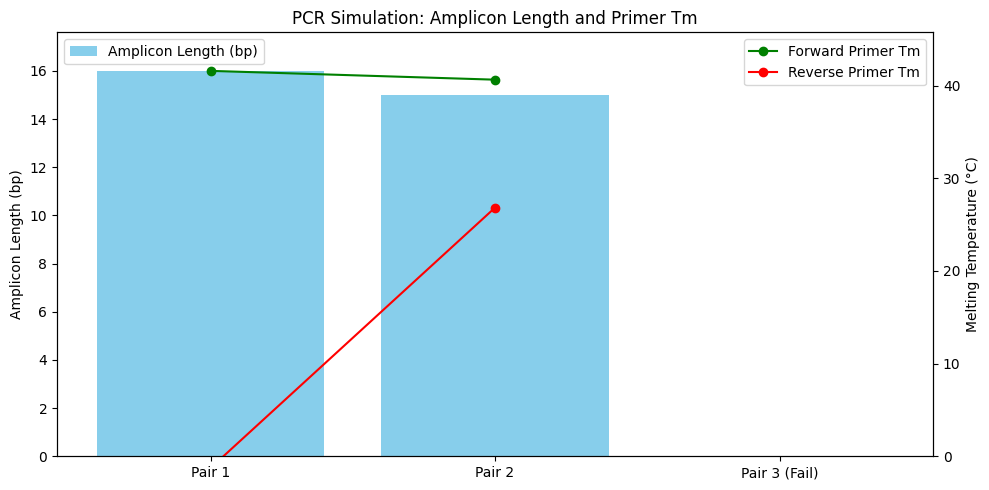

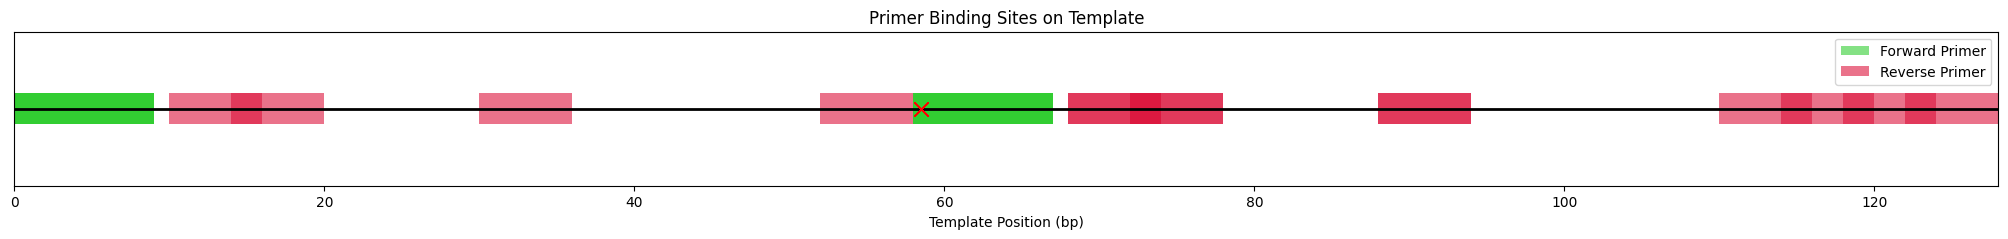

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

# --- Sequence Utilities ---

def reverse_complement(seq):
    complement = str.maketrans('ATGC', 'TACG')
    return seq.upper().translate(complement)[::-1]

def calculate_gc_content(seq):
    seq = seq.upper()
    gc_count = seq.count('G') + seq.count('C')
    return round((gc_count / len(seq)) * 100, 2)

def gc_clamp_score(seq, clamp_len=3):
    clamp_seq = seq[-clamp_len:].upper()
    return sum(1 for b in clamp_seq if b in ['G','C'])

# --- Mismatch and Binding ---

def hamming_distance(s1, s2):
    return sum(c1 != c2 for c1, c2 in zip(s1, s2))

def find_binding_sites(template, primer, max_mismatches=1):
    template = template.upper()
    primer = primer.upper()
    p_len = len(primer)
    hits = []
    for i in range(len(template) - p_len + 1):
        window = template[i:i+p_len]
        mismatches = hamming_distance(window, primer)
        if mismatches <= max_mismatches:
            mismatch_positions = [pos for pos, (a,b) in enumerate(zip(window, primer)) if a!=b]
            hits.append({'index': i, 'mismatches': mismatches, 'mismatch_positions': mismatch_positions})
    return hits

# --- Santa Lucia Nearest-Neighbor Tm ---

NN_PARAMS = {
    'AA': -7.9, 'TT': -7.9,
    'AT': -7.2, 'TA': -7.2,
    'CA': -8.5, 'TG': -8.5,
    'GT': -8.4, 'AC': -8.4,
    'CT': -7.8, 'AG': -7.8,
    'GA': -8.2, 'TC': -8.2,
    'CG': -10.6,'GC': -9.8,
    'GG': -8.0, 'CC': -8.0
}

NN_ENTROPY = {
    'AA': -22.2, 'TT': -22.2,
    'AT': -20.4, 'TA': -21.3,
    'CA': -22.7, 'TG': -22.7,
    'GT': -22.4, 'AC': -22.4,
    'CT': -21.0, 'AG': -21.0,
    'GA': -22.2, 'TC': -22.2,
    'CG': -27.2, 'GC': -24.4,
    'GG': -19.9, 'CC': -19.9
}

def calc_tm_santalucia(seq, salt_conc=0.05, oligo_conc=2.5e-7):
    seq = seq.upper()
    if len(seq) < 2:
        return 2*(seq.count('A')+seq.count('T')) + 4*(seq.count('G')+seq.count('C'))
    delta_h = 0
    delta_s = 0
    for i in range(len(seq)-1):
        pair = seq[i:i+2]
        delta_h += NN_PARAMS.get(pair, -7.0)
        delta_s += NN_ENTROPY.get(pair, -20.0)
    init_h = 0.2
    init_s = -5.7
    delta_h += init_h
    delta_s += init_s
    R = 1.987
    try:
        tm_kelvin = (1000 * delta_h) / (delta_s + R * np.log(oligo_conc / 4))
    except:
        return 2*(seq.count('A')+seq.count('T')) + 4*(seq.count('G')+seq.count('C'))
    salt_correction = 16.6 * (salt_conc**0.5)
    tm_celsius = tm_kelvin - 273.15 + salt_correction
    return round(tm_celsius, 2)

def calculate_tm(seq):
    try:
        return calc_tm_santalucia(seq)
    except:
        # Fallback Wallace rule
        return 2 * (seq.count('A') + seq.count('T')) + 4 * (seq.count('G') + seq.count('C'))

# --- Secondary structure checks ---

def check_hairpin(seq, min_loop=3, min_stem=4):
    seq = seq.upper()
    for i in range(len(seq) - min_stem*2 - min_loop + 1):
        stem1 = seq[i:i+min_stem]
        for j in range(i + min_stem + min_loop, len(seq) - min_stem + 1):
            stem2 = seq[j:j+min_stem]
            if stem1 == reverse_complement(stem2):
                return True
    return False

def check_self_dimer(seq, min_stem=4):
    seq = seq.upper()
    rev_comp = reverse_complement(seq)
    for length in range(min_stem, len(seq)//2 + 1):
        for i in range(len(seq) - length + 1):
            sub = seq[i:i+length]
            if rev_comp.find(sub) != -1:
                return True
    return False

def check_cross_dimer(seq1, seq2, min_stem=4):
    seq1 = seq1.upper()
    seq2 = seq2.upper()
    rev_comp2 = reverse_complement(seq2)
    for length in range(min_stem, min(len(seq1), len(seq2)) + 1):
        for i in range(len(seq1) - length + 1):
            sub = seq1[i:i+length]
            if rev_comp2.find(sub) != -1:
                return True
    return False

# --- Primer analysis ---

def analyze_primer(primer):
    return {
        'Tm (°C)': calculate_tm(primer),
        'GC%': calculate_gc_content(primer),
        'GC clamp (3\')': gc_clamp_score(primer) > 0,
        'GC clamp score': gc_clamp_score(primer),
        'Hairpin': check_hairpin(primer),
        'Self-dimer': check_self_dimer(primer)
    }

# --- PCR simulation ---

def run_drylab_pcr(template, fwd_primer, rev_primer, max_mismatches=1, min_amplicon=30, max_amplicon=300):
    template = template.upper()
    fwd_primer = fwd_primer.upper()
    rev_primer_rc = reverse_complement(rev_primer)

    fwd_sites = find_binding_sites(template, fwd_primer, max_mismatches)
    rev_sites = find_binding_sites(template, rev_primer_rc, max_mismatches)

    amplicons = []
    for fwd_hit in fwd_sites:
        for rev_hit in rev_sites:
            if fwd_hit['index'] < rev_hit['index']:
                amplicon_len = (rev_hit['index'] + len(rev_primer)) - fwd_hit['index']
                if min_amplicon <= amplicon_len <= max_amplicon:
                    amplicon_seq = template[fwd_hit['index']:rev_hit['index'] + len(rev_primer)]
                    amplicons.append({
                        'amplicon_sequence': amplicon_seq,
                        'amplicon_length': amplicon_len,
                        'fwd_index': fwd_hit['index'],
                        'fwd_mismatches': fwd_hit['mismatches'],
                        'fwd_mismatch_positions': fwd_hit['mismatch_positions'],
                        'rev_index': rev_hit['index'],
                        'rev_mismatches': rev_hit['mismatches'],
                        'rev_mismatch_positions': rev_hit['mismatch_positions'],
                        'forward_tm': calculate_tm(fwd_primer),
                        'reverse_tm': calculate_tm(rev_primer)
                    })

    fwd_analysis = analyze_primer(fwd_primer)
    rev_analysis = analyze_primer(rev_primer)

    result = {
        'forward_primer': fwd_primer,
        'reverse_primer': rev_primer,
        'forward_primer_analysis': fwd_analysis,
        'reverse_primer_analysis': rev_analysis,
        'amplicons': amplicons,
        'cross_dimer': check_cross_dimer(fwd_primer, rev_primer)
    }

    if amplicons:
        result['status'] = 'PASS'
        result['reason'] = f'Found {len(amplicons)} valid amplicon(s).'
    else:
        result['status'] = 'FAIL'
        result['reason'] = 'Primers not found (with allowed mismatches) or no valid amplicon length.'

    return result

def run_multiple_primer_pairs(template, primer_pairs, max_mismatches=1, min_amplicon=30, max_amplicon=300):
    results = []
    for i, (fwd, rev) in enumerate(primer_pairs, 1):
        res = run_drylab_pcr(template, fwd, rev, max_mismatches, min_amplicon, max_amplicon)
        res['pair_id'] = i
        results.append(res)
    return results

# --- Visualization ---

def plot_tm_amplicon(results_list):
    # results_list is list of results from multiple pairs
    tms_fwd = []
    tms_rev = []
    lengths = []
    labels = []

    for res in results_list:
        if res['status'] == 'PASS' and res['amplicons']:
            amp = res['amplicons'][0]
            tms_fwd.append(amp['forward_tm'])
            tms_rev.append(amp['reverse_tm'])
            lengths.append(amp['amplicon_length'])
            labels.append(f"Pair {res['pair_id']}")
        else:
            tms_fwd.append(float('nan'))
            tms_rev.append(float('nan'))
            lengths.append(0)
            labels.append(f"Pair {res['pair_id']} (Fail)")

    fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.bar(labels, lengths, color='skyblue', label='Amplicon Length (bp)')
    ax1.set_ylabel('Amplicon Length (bp)')
    ax1.set_ylim(0, max(lengths)*1.1 if max(lengths) > 0 else 10)

    ax2 = ax1.twinx()
    ax2.plot(labels, tms_fwd, color='green', marker='o', linestyle='-', label='Forward Primer Tm')
    ax2.plot(labels, tms_rev, color='red', marker='o', linestyle='-', label='Reverse Primer Tm')
    max_tm = max(
        [tm for tm in tms_fwd + tms_rev if not np.isnan(tm)],
        default=60
    )
    ax2.set_ylabel('Melting Temperature (°C)')
    ax2.set_ylim(0, max_tm * 1.1)

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.title('PCR Simulation: Amplicon Length and Primer Tm')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_binding_sites(template, results):
    fig, ax = plt.subplots(figsize=(max(len(template)/5,10), 2))
    ax.set_xlim(0, len(template))
    ax.set_ylim(0, 10)
    ax.set_yticks([])
    ax.set_xlabel('Template Position (bp)')
    ax.set_title('Primer Binding Sites on Template')

    ax.hlines(5, 0, len(template), colors='black', linewidth=2)

    fwd_color = 'limegreen'
    rev_color = 'crimson'

    # Track plotted labels to avoid duplicates in legend
    labels_added = set()

    for i, amp in enumerate(results.get('amplicons', [])):
        # Forward primer binding
        if 'Forward Primer' not in labels_added:
            label_fwd = 'Forward Primer'
            labels_added.add('Forward Primer')
        else:
            label_fwd = None
        ax.add_patch(
            patches.Rectangle(
                (amp['fwd_index'], 4), len(results['forward_primer']), 2,
                facecolor=fwd_color, alpha=0.6, label=label_fwd
            )
        )
        for pos in amp['fwd_mismatch_positions']:
            ax.plot(amp['fwd_index'] + pos + 0.5, 5, 'x', color='red', markersize=10)

        # Reverse primer binding
        if 'Reverse Primer' not in labels_added:
            label_rev = 'Reverse Primer'
            labels_added.add('Reverse Primer')
        else:
            label_rev = None
        ax.add_patch(
            patches.Rectangle(
                (amp['rev_index'], 4), len(results['reverse_primer']), 2,
                facecolor=rev_color, alpha=0.6, label=label_rev
            )
        )
        for pos in amp['rev_mismatch_positions']:
            ax.plot(amp['rev_index'] + pos + 0.5, 5, 'x', color='red', markersize=10)

    ax.legend()
    plt.show()

# --- Example Usage ---

if __name__ == "__main__":
    template = ("ATGCGTACGTTAGCTAGCTACGATCGATCGTAGCTAGCATCGATCGATCGGCTAGCTA"
                "TTGCGTACGTTAGCTAGCTACGATCGATCGTAGCTAGCATCGATCGATCGGCTAGCTAGCTAGCTAGCTA")

    primer_pairs = [
        ("ATGCGTACG", "TAGCTA"),        # should PASS
        ("CGTACGTTAG", "GCTAGCTA"),    # should PASS
        ("AAAAAAA", "TTTTTTT"),        # should FAIL
    ]

    results = run_multiple_primer_pairs(template, primer_pairs, max_mismatches=1, min_amplicon=10, max_amplicon=100)

    from pprint import pprint
    for r in results:
        pprint(r)
        print()

    plot_tm_amplicon(results)

    # Plot binding sites for first pair that passed (if any)
    for r in results:
        if r['status'] == 'PASS':
            plot_binding_sites(template, r)
            break
